In [49]:
import pandas as pd
import numpy as np
import re
import ast

import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [2]:
processed_data_path = '../data/processed/'
raw_data_path = '../data/raw/'

name = 'hd'

reviews_pro = pd.read_csv(processed_data_path + name + '_reviews.csv')
resumme_raw = pd.read_csv(raw_data_path + 'resumme_' + name + '.csv')

display(resumme_raw)
display(reviews_pro.sample(5))

reviews = reviews_pro.copy()
resumme = resumme_raw.copy()

,stars,reviews
0,5,2290
1,4,1308
2,3,396
3,2,132
4,1,128


,review_id,review,local_guide_reviews,rating_score,service,meal_type,price_per_person_category,food_score,service_score,atmosphere_score,recommendations_list,date,avg_price_per_person
140,140,Llevo años pidiendo la famosa egg-burger.\nInc...,24.0,5.0,Comí allí,Cena,20-30 €,5.0,5.0,5.0,['Hamburguesa Completa Con Huevo'],2024-01-01,30.0
286,286,Precioso lugar,9.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,[''],2018-01-01,NaN
27,27,Buen local con terraza. Las hamburguesas están...,612.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,[''],2021-01-01,NaN
222,222,Un lugar muy agradable para relajarse y disfru...,20.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,[''],2017-01-01,NaN
94,94,Iba con optimismo ya que tengo aprecio a este ...,47.0,2.0,Comí allí,Brunch,NaN,NaN,NaN,NaN,[''],2022-01-01,NaN


### First draft summary plots 

In [5]:
# Calculate the average for each score
average_food = reviews['food_score'].mean()
average_service = reviews['service_score'].mean()
average_atmosphere = reviews['atmosphere_score'].mean()
average_reviews = (resumme_raw['stars'] * resumme_raw['reviews']).sum() / resumme_raw['reviews'].sum()

# Create a figure with horizontal subplots
fig = make_subplots(rows=1, cols=3, 
                    specs=[[{"type": "xy"}, {"type": "bar"}, {"type": "bar"}]], 
                    subplot_titles=("Average Score", "Number of Reviews", "Categories"))

# First subplot: Display the average review as large text
fig.add_trace(
    go.Scatter(x=[0], y=[0], text=[f"{average_reviews:.2f}"], mode="text", textfont=dict(size=120)),
    row=1, col=1
)

fig.update_xaxes(showgrid=False, zeroline=False, showticklabels=False, row=1, col=1)
fig.update_yaxes(showgrid=False, zeroline=False, showticklabels=False, row=1, col=1)


# Second subplot: Bar plot for reviews
fig.add_trace(
    go.Bar(x=resumme_raw['reviews'], y=resumme_raw['stars'], marker=dict(color='lightskyblue'),
           text=resumme_raw['reviews'], textposition='auto', name="Reviews", orientation='h'),
    row=1, col=2
)

# Third subplot: Bar plot for categories (Food, Service, Atmosphere)
fig.add_trace(
    go.Bar(x=[average_food, average_service, average_atmosphere], 
           y=['Food', 'Service', 'Atmosphere'], 
           marker=dict(color='lightgreen'), 
           text=[f"{average_food:.2f}", f"{average_service:.2f}", f"{average_atmosphere:.2f}"], 
           textposition='auto', 
           orientation='h', 
           name="Categories"),
    row=1, col=3
)

# Update layout
fig.update_layout(height=500, width=1200,  plot_bgcolor="white", paper_bgcolor="white", showlegend=False)

# Show the plot
fig.show()

In [6]:
# Convert date column to datetime format
reviews['date'] = pd.to_datetime(reviews['date'], errors='coerce')
reviews['month'] = reviews['date'].dt.to_period('M')
reviews['year'] = reviews['date'].dt.year
reviews['week'] = reviews['date'].dt.to_period('W')
reviews['week'] = reviews['date'] - pd.to_timedelta(reviews['date'].dt.weekday, unit='d')
reviews['week'] = reviews['week'].dt.strftime('%Y-%m-%d')

# Filter data for the last periods (months, years, weeks)
last_months = reviews[reviews['date'] >= pd.to_datetime('today') - pd.DateOffset(months=12)]
last_years = reviews[reviews['date'] >= pd.to_datetime('today') - pd.DateOffset(years=8)]
last_weeks = reviews[reviews['date'] >= pd.to_datetime('today') - pd.DateOffset(weeks=5)]

# Compute averages for the required periods
monthly_avg_scores = last_months.groupby('month')[['rating_score', 'food_score', 'service_score', 'atmosphere_score']].mean()
yearly_avg_scores = last_years.groupby('year')[['rating_score']].mean()
weekly_avg_scores = last_weeks.groupby('week')[['rating_score', 'food_score', 'service_score', 'atmosphere_score']].mean()

# Update the axis labels for each score to be more readable
label_mapping = {
    'rating_score': 'Rating',
    'food_score': 'Food',
    'service_score': 'Service',
    'atmosphere_score': 'Atmosphere'
}

# Create a figure with subplots using the Z-layout
fig = make_subplots(rows=2, cols=2,
                    specs=[[{"colspan": 2}, None],
                           [{}, {}]],  # 1 large plot on the first row, 2 smaller plots on the second
                    subplot_titles=("Monthly Score Trends (Last 12 Months)", 
                                    "Annual Rating Score Trends (Last 6 Years)", 
                                    "Weekly Score Trends (Last 4 Weeks)"))

# Add monthly score trends to the first row (rating_score in stronger color)
colors = ['#1f77b4', '#aec7e8', '#aec7e8', '#aec7e8']  # Same tonal range, rating_score stronger
for i, column in enumerate(monthly_avg_scores.columns):
    label = label_mapping[column]  # Get the readable label
    fig.add_trace(
        go.Scatter(x=monthly_avg_scores.index.astype(str), y=monthly_avg_scores[column],
                   mode='lines+markers', name=label, 
                   text=[f"{label} - {val:.2f}" for val in monthly_avg_scores[column]], 
                   hoverinfo="text", line=dict(color=colors[i])),
        row=1, col=1)

# Add yearly score trends to the second row (left)
fig.add_trace(
    go.Scatter(x=yearly_avg_scores.index.astype(str), y=yearly_avg_scores['rating_score'],
               mode='lines+markers', name="Rating", line=dict(color='#1f77b4', width=4),
               text=[f"Rating - {val:.2f}" for val in yearly_avg_scores['rating_score']], 
               hoverinfo="text"),
    row=2, col=1)

# Add weekly score trends to the second row (right, weaker colors)
for i, column in enumerate(weekly_avg_scores.columns):
    label = label_mapping[column]  # Get the readable label
    fig.add_trace(
        go.Scatter(x=weekly_avg_scores.index.astype(str), y=weekly_avg_scores[column],
                   mode='lines+markers', name=label, 
                   text=[f"{label} - {val:.2f}" for val in weekly_avg_scores[column]], 
                   hoverinfo="text", line=dict(color=colors[i])),
        row=2, col=2)

# Enhance presentation: remove gridlines and borders, increase size, and remove legend
fig.update_layout(showlegend=False, 
                  title="Score Trends Analysis",
                  title_font=dict(size=28),
                  margin=dict(l=50, r=50, t=100, b=50),
                  paper_bgcolor="white",
                  height=800, width=1200)

# Remove unnecessary gridlines for a cleaner look
fig.update_xaxes(showline=False, showgrid=False)
fig.update_yaxes(showline=False, showgrid=True)

# Customize x-axes formatting: show only the year for yearly data, and only day and month for weekly data
fig.update_xaxes(
    tickformat="%Y",  # Only show the year for the yearly graph
    row=2, col=1
)

fig.update_xaxes(
    tickformat="%d-%b",  # Show only the day and month for weekly graph
    row=2, col=2
)

# Add annotations to highlight key points
fig.add_annotation(x='2024-06', y=4.8, 
                   text="Highest Score", 
                   showarrow=True, arrowhead=2,
                   ax=0, ay=80, row=1, col=1, font=dict(size=14))

fig.add_annotation(x='2024-03', y=4.5, 
                   text="Drop in March", 
                   showarrow=True, arrowhead=2,
                   ax=0, ay=-40, row=1, col=1, font=dict(size=14))

fig.add_annotation(x='2024-08', y=4.5, 
                   text="Drop in August", 
                   showarrow=True, arrowhead=2,
                   ax=0, ay=-40, row=1, col=1, font=dict(size=14))

# Improve line aesthetics (rating score with more prominence)
fig.update_traces(marker=dict(size=8), selector=dict(name="Rating"))

# Display the interactive plot
fig.show()


### Cleaning and preprocessing

In [11]:
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

from tqdm import tqdm

# Download NLTK stopwords and lexicon
nltk.download('stopwords')
nltk.download('vader_lexicon')

# Load spaCy Spanish model
nlp = spacy.load('es_core_news_sm')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jobandtalent/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jobandtalent/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [5]:
# Clean text, stopworks and tokenize words
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-záéíóúñü0-9\s]', '', text)
    doc = nlp(text)
    stop_words = set(stopwords.words('spanish'))
    tokens = [token.lemma_ for token in doc 
              if token.text not in stop_words and not token.is_punct and not token.is_space]
    return ' '.join(tokens)

In [6]:
tqdm.pandas(desc="Cleaning Reviews")
reviews['cleaned_review'] = reviews['review'].fillna('').progress_apply(clean_text)

display(reviews[['review', 'cleaned_review']].sample(5))

Cleaning Reviews: 100%|██████████| 360/360 [00:02<00:00, 154.30it/s]


,review,cleaned_review
143,La hamburguesa italiana de las mejores q he pr...,hamburguesa italiano mejor q probar precio raz...
25,Cafetería emblemática madrileña abierta por lo...,cafetería emblemático madrileño abierto herman...
117,"UN LOCAL CON AIRE OCHENTERO DONDE EL SERVICIO,...",local aire ochentero servicio calidad variedad...
12,Fui por casualidad con unos amigos... me encan...,casualidad amigo encantar hamburguesa espectác...
13,Un clásico en la zona de Chamberí.\n\nPROS: la...,clásico zona chamberir pro hamburguesa genial ...


### Embeddings and sentiment analysis

In [7]:
# Embeddings and Sentiment
from transformers import pipeline
from transformers import BertTokenizer, BertModel
import torch

# Word Clouds and Visualization
from wordcloud import WordCloud


#### Calculate embeddings

In [8]:
# Extract the embeddings for each cleaned review
def get_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Import Bert model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained('bert-base-multilingual-cased')

tqdm.pandas(desc="Generating Embeddings")
reviews['embedding'] = reviews['cleaned_review'].progress_apply(get_embedding)

Generating Embeddings: 100%|██████████| 360/360 [00:30<00:00, 11.82it/s]


In [9]:
reviews

,review_id,review,local_guide_reviews,rating_score,service,meal_type,price_per_person_category,food_score,service_score,atmosphere_score,recommendations_list,date,avg_price_per_person,cleaned_review,embedding
0,0,Además de que da un vibra de un bar de los 50’...,92.0,5.0,NaN,NaN,NaN,5.0,5.0,5.0,[''],2024-09-09,NaN,además dar vibra bar 50s hamburguesa descubrim...,"[-0.39345536, -0.33803207, 0.34808198, 0.19436..."
1,1,La hamburguesa de pollo frito estaba muy rica ...,35.0,4.0,Comí allí,Comida,30-40 €,4.0,5.0,4.0,[''],2024-08-01,40.0,hamburguesa pollo frito rico acuerdo nombre ca...,"[-0.13622372, -0.16634203, 0.5213568, 0.331580..."
2,2,Estuve cenando en familia el martes y además d...,2.0,5.0,NaN,NaN,NaN,5.0,5.0,5.0,[''],2024-09-16,NaN,cenar familia martes además excelente atención...,"[-0.29606187, -0.28629205, 0.2620312, 0.217695..."
3,3,Solo tomamos un vermút y una cerveza. El bar m...,11.0,3.0,NaN,NaN,NaN,NaN,3.0,3.0,[''],2024-05-01,NaN,solo tomar vermút cerveza bar molo cafeteer sa...,"[-0.36835817, -0.26008305, 0.064508475, 0.3708..."
4,4,"Un gofre frío y tieso 9,20€? Nunca me había se...",58.0,1.0,NaN,NaN,NaN,1.0,1.0,2.0,[''],NaN,NaN,gofre frío tieso 920 nunca tanto estafado 3 ba...,"[9.475763e-05, -0.38498864, -0.15247194, 0.622..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,355,NaN,81.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,[''],2023-01-01,NaN,,"[0.1206212, -0.15257965, 1.012721, 0.37729222,..."
356,356,NaN,30.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,[''],2023-01-01,NaN,,"[0.1206212, -0.15257965, 1.012721, 0.37729222,..."
357,357,NaN,51.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,[''],2023-01-01,NaN,,"[0.1206212, -0.15257965, 1.012721, 0.37729222,..."
358,358,NaN,2.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,[''],2023-01-01,NaN,,"[0.1206212, -0.15257965, 1.012721, 0.37729222,..."


#### Analyze sentiment

In [50]:
def analyze_sentiment_vader(df):
    # Initialize VADER sentiment analyzer
    sia = SentimentIntensityAnalyzer()

    # Apply sentiment analysis to each review using VADER
    df['vader_sentiment'] = df['cleaned_review'].apply(lambda x: sia.polarity_scores(x)['compound'])
    
    # Classify sentiment into positive, neutral, negative using rating_score and vader_sentiment
    def classify_sentiment(row):
        if row['rating_score'] >= 4:
            return 'positive'
        elif row['rating_score'] <= 2:
            return 'negative'
        elif row['vader_sentiment'] > 0.05:
            return 'positive'
        elif row['vader_sentiment'] < -0.05:
            return 'negative'
        else:
            return 'neutral'
    
    df['sentiment_label'] = df.apply(classify_sentiment, axis=1)
    
    return df

def generate_ngram_analysis(df, sentiment_label='positive', n=2, top_n=10):
    # Filter reviews by sentiment label
    reviews_text = df[df['sentiment_label'] == sentiment_label]['cleaned_review'].fillna('').tolist()
    
    # Create n-grams for the given sentiment label
    vectorizer = CountVectorizer(ngram_range=(n, n)).fit(reviews_text)
    ngrams = vectorizer.transform(reviews_text)
    
    # Sum all n-grams
    ngram_counts = ngrams.sum(axis=0)
    ngram_freq = [(word, ngram_counts[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    sorted_ngrams = sorted(ngram_freq, key=lambda x: x[1], reverse=True)[:top_n]
    
    return sorted_ngrams

def extract_common_phrases(df, sentiment_label='positive', n=10):
    # Filter reviews by sentiment label
    filtered_reviews = df[df['sentiment_label'] == sentiment_label]['cleaned_review'].fillna('').tolist()
    
    # Tokenize and count words for the given sentiment label
    vectorizer = CountVectorizer().fit(filtered_reviews)
    word_counts = vectorizer.transform(filtered_reviews).sum(axis=0)
    
    # Create a dictionary of word frequencies
    word_freq = [(word, word_counts[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    sorted_word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)[:n]
    
    return sorted_word_freq

In [42]:
#  Analyze sentiment with VADER
reviews = analyze_sentiment_vader(reviews)

In [45]:
# Generate bigrams
bigrams = generate_ngram_analysis(reviews, n=2)


In [64]:
def plot_sentiment_percentage_trend(df):
    # Convert date to datetime format and handle missing values
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df = df.dropna(subset=['date'])
    
    # Filter only the last 6 years
    last_six_years = datetime.datetime.now() - pd.DateOffset(years=6)
    df = df[df['date'] >= last_six_years]

    # Set date as index for resampling
    df.set_index('date', inplace=True)
    
    # Resample to monthly and count sentiments
    sentiment_counts = df.resample('M')['sentiment_label'].value_counts().unstack().fillna(0)

    # Calculate the percentage for each sentiment type
    sentiment_percentage = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100
    sentiment_percentage = sentiment_percentage.round(2)
    sentiment_percentage = sentiment_percentage.reset_index().melt(id_vars=['date'], value_name='percentage', var_name='sentiment_label')
    
    # Plot sentiment percentage evolution
    fig = px.area(
        sentiment_percentage,
        x='date',
        y='percentage',
        color='sentiment_label',
        title='Sentiment Percentage Over the Last 6 Years',
        labels={'date': '', 'percentage': 'Percentage of Reviews (%)', 'sentiment_label': 'Sentiment'},
        template='plotly_white',
    )

    # Customize layout for a clean look
    fig.update_layout(
        title=dict(x=0.5, xanchor='center', font=dict(size=18, color='black')),
        xaxis=dict(showgrid=False, zeroline=False),
        yaxis=dict(showgrid=True, title='Percentage of Reviews', ticksuffix='%'),
        legend=dict(title='', orientation='h', yanchor='bottom', y=1.02, xanchor='right', x=1),
        margin=dict(l=20, r=20, t=50, b=20),
        plot_bgcolor='rgba(0,0,0,0)',
        hovermode='x unified',
        width=1200,  # Make the plot narrower
        height=400,
    )

    # Customize color for sentiment categories with softer tones
    color_map = {
        'positive': 'rgba(102, 194, 165, 0.7)',  # Soft green with transparency
        'neutral': 'rgba(141, 160, 203, 0.7)',   # Soft blue with transparency
        'negative': 'rgba(252, 141, 98, 0.7)'    # Soft orange with transparency
    }
    fig.for_each_trace(lambda trace: trace.update(line=dict(width=0, shape='spline'), fill='tonexty', fillcolor=color_map.get(trace.name, 'rgba(150, 150, 150, 0.5)')))

    # Remove the plot frame and keep the visualization as clean as possible
    fig.update_xaxes(showline=False)
    fig.update_yaxes(showline=False, range=[0, 100])  # Percentage scale from 0 to 100

    fig.show()

In [65]:
plot_sentiment_percentage_trend(reviews)

/var/folders/hv/ckh3m6gn1sd45q2qctrqcwzh0000gn/T/ipykernel_27970/455122672.py:14: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



In [97]:
# Extract common positive and negative phrases
common_positive_phrases = extract_common_phrases(reviews, sentiment_label = 'positive', n = 10)
common_negative_phrases = extract_common_phrases(reviews, sentiment_label = 'negative', n = 10)

# Display results
print("Top 10 Positive Words:", common_positive_phrases)
print("Top 10 Negative Words:", common_negative_phrases)

Top 10 Positive Words: [('hamburguesa', 128), ('buen', 118), ('comida', 66), ('lugar', 65), ('servicio', 48), ('sitio', 46), ('bien', 44), ('mejor', 42), ('precio', 41), ('ambiente', 36)]
Top 10 Negative Words: [('ir', 10), ('café', 10), ('vez', 8), ('ver', 8), ('si', 8), ('pedir', 8), ('sitio', 7), ('servicio', 7), ('comida', 7), ('parecer', 6)]


In [96]:
def extract_common_ngrams(df, sentiment_label='positive', n=2, top_n=10):
    # Filter reviews by sentiment label
    filtered_reviews = df[df['sentiment_label'] == sentiment_label]['cleaned_review'].fillna('').tolist()
    
    # Create n-grams for the given sentiment label
    vectorizer = CountVectorizer(ngram_range=(n, n)).fit(filtered_reviews)
    ngram_counts = vectorizer.transform(filtered_reviews).sum(axis=0)
    
    # Create a list of n-grams with their counts
    ngram_freq = [(word, ngram_counts[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    sorted_ngrams = sorted(ngram_freq, key=lambda x: x[1], reverse=True)[:top_n]
    
    return sorted_ngrams

# Extract common positive and negative bigrams
common_positive_bigrams = extract_common_ngrams(reviews, sentiment_label='positive', n=2, top_n=10)
common_negative_bigrams = extract_common_ngrams(reviews, sentiment_label='negative', n=2, top_n=10)

# Display results
print("Top Positive Bigrams:", common_positive_bigrams)
print("Top Negative Bigrams:", common_negative_bigrams)

Top Positive Bigrams: [('comida buen', 11), ('buen ambiente', 11), ('mejor hamburguesa', 11), ('buen comida', 10), ('buen servicio', 9), ('buen lugar', 8), ('aro cebolla', 7), ('hamburguesa rico', 7), ('precio razonable', 7), ('hamburguesa italiano', 6)]
Top Negative Bigrams: [('ver foto', 3), ('merecer pena', 3), ('nunca tanto', 2), ('si solo', 2), ('último vez', 2), ('huevo revuelto', 2), ('dar yo', 2), ('acompañar hamburguesa', 2), ('pan mohoso', 2), ('gofre frío', 1)]


In [100]:

def analyze_recommended_dishes(df):
    all_dishes = []

    # Convert string representation of lists to actual lists and extend all_dishes
    for item in df['recommendations_list'].dropna():
        try:
            dishes = ast.literal_eval(item)
            if isinstance(dishes, list):
                all_dishes.extend(dishes)
        except:
            continue

    # Filter out empty values
    all_dishes = [dish for dish in all_dishes if dish.strip() != '']

    # Count the frequency of each dish
    dish_counts = Counter(all_dishes)

    # Most and least recommended dishes
    most_common_dishes = dish_counts.most_common(3)
    min_count = min(dish_counts.values())
    worst_dishes = [dish for dish, count in dish_counts.items() if count == min_count]

    print("Top Most Recommended:", most_common_dishes)
    print("Least Recommended :", worst_dishes)

# Apply the function
analyze_recommended_dishes(reviews)


Top Most Recommended: [('Hamburguesa Completa Con Huevo', 9), ('Hamburguesa Americana', 8), ('Hamburguesa Italiana', 6)]
Least Recommended : ['Plaza de aparcamiento', 'Flan de Queso', 'Gofre Con Nocilla', 'Grandburguer HD', 'Hamburger', 'Hamburguesa Con Huevo', 'Tarta de Manzana', 'Tataki de Atún', 'Cheesecake', 'Hamburguesa Gallega', 'Brunch Con Baggel Salmón']


#### Analyze embeddings

In [102]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

def evaluate_sentiment_factors(df):
    # Prepare data for regression analysis
    X = df[['food_score', 'service_score', 'price_per_person_category']].dropna()
    X['price_per_person_category'] = X['price_per_person_category'].map({'<10 €': 1, '10-20 €': 2, '20-30 €': 3, '30-40 €': 4, '>40 €': 5})
    y = df['sentiment_label'].map({'positive': 1, 'negative': 0}).dropna()

    # Align X and y indices
    X, y = X.align(y, join='inner', axis=0)

    # Add constant for logistic regression
    X = sm.add_constant(X)

    # Fit logistic regression model
    model = sm.Logit(y, X)
    result = model.fit()

    # Print summary to understand importance of each factor
    print(result.summary())

# Apply function
evaluate_sentiment_factors(reviews)


MissingDataError: exog contains inf or nans

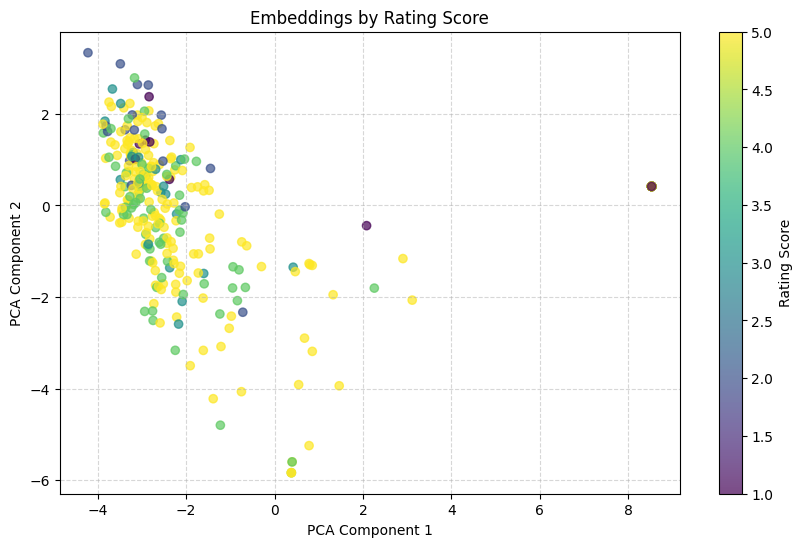

In [103]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def analyze_embeddings_by_rating(df):
    embeddings = np.array(df['embedding'].tolist())
    ratings = df['rating_score']

    # Reduce dimensionality with PCA for visualization
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)

    # Scatter plot colored by rating score
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=ratings, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, label='Rating Score')
    plt.title('Embeddings by Rating Score')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# Apply function
analyze_embeddings_by_rating(reviews)

In [105]:
from gensim import corpora
from gensim.models import LdaModel

def analyze_topics_with_lda(df):
    # Prepare corpus for LDA
    cleaned_reviews = df['cleaned_review'].dropna().tolist()
    tokenized_reviews = [review.split() for review in cleaned_reviews]
    dictionary = corpora.Dictionary(tokenized_reviews)
    corpus = [dictionary.doc2bow(review) for review in tokenized_reviews]

    # Train LDA model
    lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10)

    # Print topics
    topics = lda_model.print_topics(num_words=5)
    for topic in topics:
        print(f"Topic {topic[0]}: {topic[1]}")
    return lda_model, topics

# Apply function
lda_model, topics = analyze_topics_with_lda(reviews)


Topic 0: 0.026*"hamburguesa" + 0.010*"madrid" + 0.010*"poder" + 0.009*"mejor" + 0.009*"precio"
Topic 1: 0.027*"buen" + 0.021*"hamburguesa" + 0.019*"comida" + 0.015*"servicio" + 0.010*"excelente"
Topic 2: 0.023*"buen" + 0.020*"hamburguesa" + 0.012*"bien" + 0.011*"comida" + 0.010*"precio"
Topic 3: 0.021*"buen" + 0.010*"hamburguesa" + 0.008*"buena" + 0.007*"bastante" + 0.007*"volver"
Topic 4: 0.022*"lugar" + 0.015*"hamburguesa" + 0.011*"comida" + 0.010*"amable" + 0.008*"ambiente"


In [106]:
def map_sentiments_to_topics(df, lda_model):
    cleaned_reviews = df['cleaned_review'].dropna().tolist()
    tokenized_reviews = [review.split() for review in cleaned_reviews]
    dictionary = corpora.Dictionary(tokenized_reviews)
    corpus = [dictionary.doc2bow(review) for review in tokenized_reviews]

    # Predict topics for each review
    df['topic'] = [max(lda_model.get_document_topics(bow), key=lambda x: x[1])[0] for bow in corpus]

    # Count the number of positive, negative reviews per topic
    topic_sentiment_counts = df.groupby(['topic', 'sentiment_label']).size().unstack(fill_value=0)
    print(topic_sentiment_counts)

# Apply function
map_sentiments_to_topics(reviews, lda_model)


sentiment_label  negative  neutral  positive
topic                                       
0                       8        9       102
1                       4        2        74
2                       8        7        82
3                       3        0        14
4                       6        5        36


In [109]:
import umap.umap_ as umap
import plotly.express as px
import numpy as np
import pandas as pd

def visualize_embeddings(df):
    embeddings = np.array(df['embedding'].tolist())
    sentiment_labels = df['sentiment_label']

    # Reduce dimensionality with UMAP
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
    reduced_embeddings = reducer.fit_transform(embeddings)

    # Create DataFrame for visualization
    viz_df = pd.DataFrame(reduced_embeddings, columns=['x', 'y'])
    viz_df['sentiment_label'] = sentiment_labels

    # Scatter plot with Plotly for interactive visualization
    fig = px.scatter(
        viz_df,
        x='x',
        y='y',
        color='sentiment_label',
        title='Embedding Visualization with UMAP',
        labels={'x': 'UMAP Dimension 1', 'y': 'UMAP Dimension 2'},
        color_discrete_map={'positive': 'green', 'neutral': 'gray', 'negative': 'red'},
        opacity=0.7
    )
    fig.update_layout(showlegend=True, legend=dict(title='Sentiment'), margin=dict(l=10, r=10, t=40, b=10))
    fig.show()

# Apply function
visualize_embeddings(reviews)


ModuleNotFoundError: No module named 'umap.umap_'

#### Extract moments with worst rating and process that reviews

#### Extract outliers and pain points

In [ ]:
## extract the reviews with negative sentiment:
# each one for very low category score
# worst 3 words
# worst 3 bigrams


In [ ]:
# put together each one in a string and send it to gpt api to extract the main pain points to improve